<a href="https://colab.research.google.com/github/anandpuntambekar/project-guidelines/blob/master/Drive_of_UK_House_PRICE_Study_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UK House Price Prediction

### Approach 

- Perform EDA on 3 Data sets Found
  - Tweet from UK
  - Geographic Information, Population
  - Price Data for UK House Prices

- Perform Mergining of Relavant Columns

- Using a Neural Network Perform Prgression
  - Handling empty variables
  - Perform Droupout, batch Norm, Learned Embedding
  - Obtain Results on validation Data Set
  - Handling large Data Set - Demostrated (Not performed Due to lack of time)
   


## Comments:

- Data was found on Opensource platforms and Violates no laws on application
- Large Data Set was handled with Chunck Size
- Interactive Geographic Charts have been Provided for teh user to See


## Mount Google Drive in order to Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Relavant Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plots
import folium
from folium import features
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# For Prediction
from fastai.tabular import *
from fastai.tabular import add_datepart

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Set 1 : EDA for Twitter Data

In [ ]:
Tweets = pd.read_csv("/content/drive/My Drive/10FA/Twitter_case_study_2_dataset.csv")
Tweets.drop('index', axis=1, inplace=True)
Tweets.head(3)

date         country   latitude  longitude   source
0  7/27/2017  United Kingdom  54.523293  -1.539852  Android
1  7/27/2017  United Kingdom  51.448727  -1.014957  Android
2  7/27/2017  United Kingdom  51.084751   1.136008  Android

### Number of Tweets by Country
#### All Terms Mean the same (In different Languages)

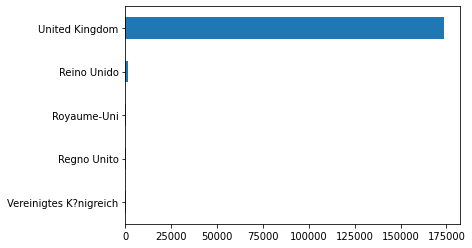

In [ ]:
Tweets.country.value_counts(ascending=True).tail().plot.barh();

### Number of Tweets by Device Type


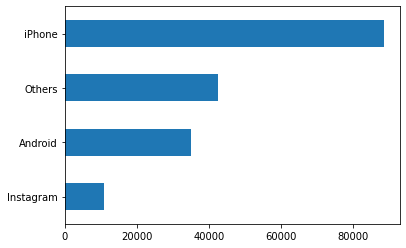

In [ ]:
Tweets.source.value_counts(ascending=True).tail().plot.barh();

### Geographic Density of Tweets

In [ ]:
df_map = folium.Map(location=[54.523293, -1.539852], zoom_start=3)
data = [[x[0], x[1], 1] for x in np.array(Tweets[['latitude', 'longitude']])]
HeatMap(data, radius = 20).add_to(df_map)
df_map

In [ ]:
'''map_wb = folium.Map(location=[54.523293, -1.539852],zoom_start=1)
mc = MarkerCluster()
for ind,row in Tweets.iterrows():
    mc.add_child(folium.CircleMarker(location=[row['latitude'],row['longitude']],
                        radius=1,color='#3185cc'))
map_wb.add_child(mc)
'''

"map_wb = folium.Map(location=[54.523293, -1.539852],zoom_start=1)\nmc = MarkerCluster()\nfor ind,row in Tweets.iterrows():\n    mc.add_child(folium.CircleMarker(location=[row['latitude'],row['longitude']],\n                        radius=1,color='#3185cc'))\nmap_wb.add_child(mc)\n"

### Keeping Tweets orignated only in the UK

In [ ]:
Tweets= Tweets[Tweets['latitude']>48.8566]
df_map = folium.Map(location=[54.523293, -1.539852], zoom_start=6)
data = [[x[0], x[1], 1] for x in np.array(Tweets[['latitude', 'longitude']])]
HeatMap(data, radius = 20).add_to(df_map)
df_map

### Time Series Visualization of the Number of Tweets

In [ ]:
Tweets['date'] = pd.to_datetime(Tweets['date'])
Tweets.head()

date         country   latitude  longitude   source
0 2017-07-27  United Kingdom  54.523293  -1.539852  Android
1 2017-07-27  United Kingdom  51.448727  -1.014957  Android
2 2017-07-27  United Kingdom  51.084751   1.136008  Android
3 2017-07-27  United Kingdom  51.308746  -0.133054  Android
4 2017-07-27  United Kingdom  52.100422   1.298388  Android

### There exist only one Date of tweets available

## Data Set 2 : EDA for City , Geography and Populations

In [ ]:
Cities = pd.read_csv("/content/drive/My Drive/10FA/worldcities.csv")
Cities= Cities[Cities['country'] == 'United Kingdom']
Cities.head(3)

city  city_ascii      lat  ...  capital population          id
25       London      London  51.5000  ...  primary  8567000.0  1826645935
177  Birmingham  Birmingham  52.4750  ...    admin  2285000.0  1826423213
181  Manchester  Manchester  53.5004  ...    admin  2230000.0  1826246335

[3 rows x 11 columns]

In [ ]:
Cities.drop('city', axis=1, inplace=True)
Cities.drop('country', axis=1, inplace=True)
Cities.drop('iso2', axis=1, inplace=True)
Cities.drop('iso3', axis=1, inplace=True)
Cities.drop('admin_name', axis=1, inplace=True)
#Cities.drop('capital', axis=1, inplace=True)
Cities.drop('id', axis=1, inplace=True)
Cities['city_ascii']=Cities['city_ascii'].str.upper()
Cities.head(3)

city_ascii      lat     lng  capital  population
25       LONDON  51.5000 -0.1167  primary   8567000.0
177  BIRMINGHAM  52.4750 -1.9200    admin   2285000.0
181  MANCHESTER  53.5004 -2.2480    admin   2230000.0

### Counting Number of Tweets per city

In [ ]:


def Count_Tweets(lat_city,long_city,ck):
   Tweets_tmp = Tweets[(Tweets['latitude']<=lat_city+ck) & (Tweets['latitude']>=lat_city-ck) & (Tweets['longitude']>=long_city-ck) & (Tweets['longitude']<=long_city+ck) ]
   #print(Tweets_tmp.shape[0])
   return Tweets_tmp.shape[0]

# Number of Tweets within 1 Degree Lat, Long
ck=1
Cities.loc[:,'Tweets_Count_1']=0
Cities['Tweets_Count_1'] = Cities.apply(lambda row: Count_Tweets(row['lat'], row['lng'], ck), axis=1)

# Number of Tweets within 0.5 Degree Lat, Long
ck=0.5
Cities.loc[:,'Tweets_Count_05']=0
Cities['Tweets_Count_05'] = Cities.apply(lambda row: Count_Tweets(row['lat'], row['lng'], ck), axis=1)

# Number of Tweets within 0.25 Degree Lat, Long
ck=0.25
Cities.loc[:,'Tweets_Count_025']=0
Cities['Tweets_Count_025'] = Cities.apply(lambda row: Count_Tweets(row['lat'], row['lng'], ck), axis=1)

# Number of Tweets within 0.1 Degree Lat, Long
ck=0.01
Cities.loc[:,'Tweets_Count_001']=0
Cities['Tweets_Count_001'] = Cities.apply(lambda row: Count_Tweets(row['lat'], row['lng'], ck), axis=1)


Cities.head(3)

city_ascii      lat  ...  Tweets_Count_025 Tweets_Count_001
25       LONDON  51.5000  ...              5531              209
177  BIRMINGHAM  52.4750  ...               469               92
181  MANCHESTER  53.5004  ...               578                0

[3 rows x 9 columns]

## Number of Tweets within 0.5 Degree Lat/Log of City Center

In [ ]:
df_map = folium.Map(location=[54.523293, -1.539852], zoom_start=5)
data = [[x[0], x[1], x[2]] for x in np.array(Cities[['lat', 'lng','Tweets_Count_05']])]
HeatMap(data, radius = 20).add_to(df_map)
df_map

## The Number of Tweets appear to have a visual Corelation to Poulation of City

## Data Set 3 : EDA for Price Data for UK

In [ ]:
Paid_Price = pd.read_csv("/content/drive/My Drive/10FA/price_paid_records.csv")
Paid_Price=Paid_Price.sample(frac = 0.2) 
Paid_Price.head(3)

Transaction unique identifier  ...  Record Status - monthly file only
11879140  {CD96F77F-BA83-48F8-8DF7-CDD0136EBC22}  ...                                  A
9259882   {416A7A2C-7A92-4350-A8DB-A9E9E089077C}  ...                                  A
951120    {89F9548E-22FC-49F2-A3DE-3CA8734804D3}  ...                                  A

[3 rows x 11 columns]

In [ ]:
Paid_Price['Date of Transfer'] = pd.to_datetime(Paid_Price['Date of Transfer'])
add_datepart(Paid_Price, 'Date of Transfer')
Paid_Price.dtypes

Transaction unique identifier        object
Price                                 int64
Property Type                        object
Old/New                              object
Duration                             object
Town/City                            object
District                             object
County                               object
PPDCategory Type                     object
Record Status - monthly file only    object
Date of TransferYear                  int64
Date of TransferMonth                 int64
Date of TransferWeek                  int64
Date of TransferDay                   int64
Date of TransferDayofweek             int64
Date of TransferDayofyear             int64
Date of TransferIs_month_end           bool
Date of TransferIs_month_start         bool
Date of TransferIs_quarter_end         bool
Date of TransferIs_quarter_start       bool
Date of TransferIs_year_end            bool
Date of TransferIs_year_start          bool
Date of TransferElapsed         

## Duplicates
First we check Paid_Price to see if there are any duplicate rows in the data, in this data we indentify none.

However, searching for duplicates on all columns except ID shows that approximately 0.05% are in fact duplicates but we can ignore this 

In [ ]:
len(Paid_Price.drop_duplicates())

4497870

House Price Distribution
Let us take a quick exploratory look at the distribution of house prices. 

I first created a histogram using plot.ly but due to the sheer size this caused performance issues so instead resorted to using a simple matplolib plot.



Remove outliers
I then reduced the data by removing extreme house prices. Those are the ones that are:

less than £10 Million and,
greater than £10,000

Text(0.5, 1.0, 'Price')

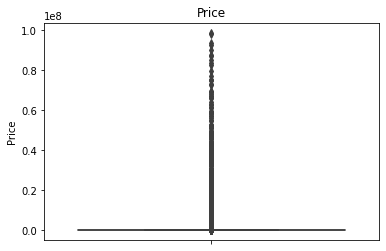

In [ ]:
sns.boxplot(y = Paid_Price['Price'])
plt.title('Price')

## Eliminate Outliers from Data

4497870
4325454


Text(0.5, 1.0, 'Price')

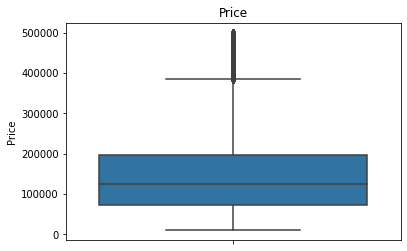

In [ ]:
print(len(Paid_Price))
Paid_Price = Paid_Price.loc[(Paid_Price['Price'] < (500000)) & (Paid_Price['Price'] > (10000))]
print(len(Paid_Price))
sns.boxplot(y = Paid_Price['Price'])
plt.title('Price')

[Text(0.5, 1.0, 'SalePrice distribution')]

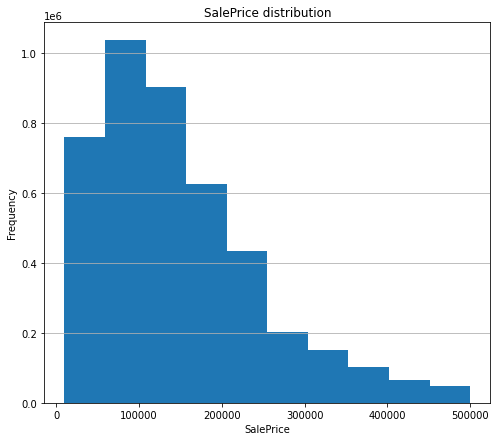

In [ ]:
#Let us take a quick exploratory look at the distribution of house prices. We see that the majority of house prices across all years is less than £500,000.
f, ax = plt.subplots(figsize=(8, 7))
#Paid_Price=Paid_Price[Paid_Price['Price']<500000]
Paid_Price['Price'].hist()
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")

## Variation of Price with County

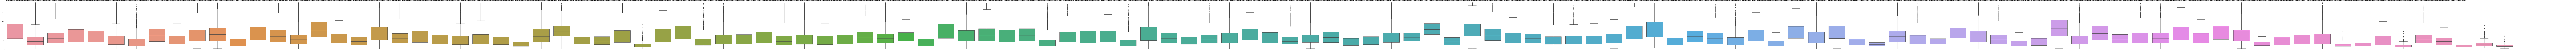

In [ ]:
data = pd.concat([Paid_Price['Price'], Paid_Price['County']], axis=1)
f, ax = plt.subplots(figsize=(600, 12))
fig = sns.boxplot(x=Paid_Price['County'], y="Price", data=data)

## Variation of Price over time

Text(0, 0.5, 'Mean House Price over Years')

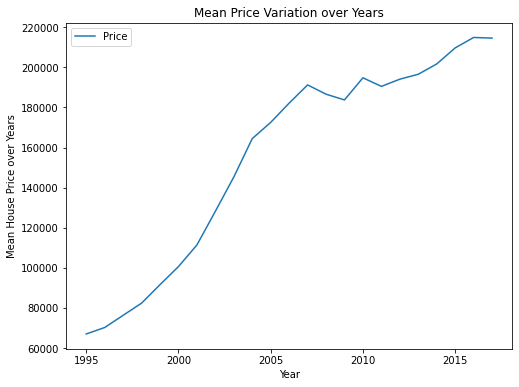

In [ ]:
Paid_Price_series=Paid_Price.groupby(['Date of TransferYear'])['Price'].mean().reset_index()
Paid_Price_series.set_index('Date of TransferYear', inplace=True)
#Paid_Price_series=Paid_Price_series[Paid_Price_series['Price']<500000]
ax=Paid_Price_series.plot(figsize= (8,6),title = 'Mean Price Variation over Years')#, xlabel='Years',ylabel = 'Mean Price Variation over Years')

# Set the x-axis label
ax.set_xlabel("Year")

# Set the y-axis label
ax.set_ylabel("Mean House Price over Years")

Text(0, 0.5, 'Mean House Price over Months')

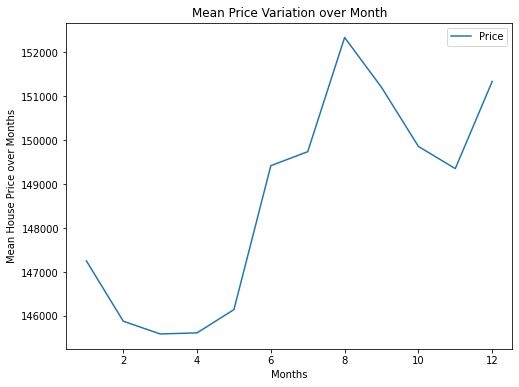

In [ ]:
Paid_Price_series=Paid_Price.groupby(['Date of TransferMonth'])['Price'].mean().reset_index()
Paid_Price_series.set_index('Date of TransferMonth', inplace=True)
#Paid_Price_series=Paid_Price_series[Paid_Price_series['Price']<500000]
ax=Paid_Price_series.plot(figsize= (8,6),title = 'Mean Price Variation over Month')#, xlabel='Years',ylabel = 'Mean Price Variation over Years')

# Set the x-axis label
ax.set_xlabel("Months")

# Set the y-axis label
ax.set_ylabel("Mean House Price over Months")

## Price Appears to drop at the begining and end of Year

Text(0, 0.5, 'Mean House Price over Day of Week')

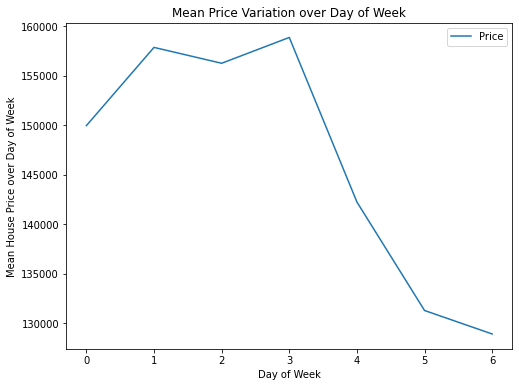

In [ ]:
#Date of TransferDayofweek             int64
Paid_Price_series=Paid_Price.groupby(['Date of TransferDayofweek'])['Price'].mean().reset_index()
Paid_Price_series.set_index('Date of TransferDayofweek', inplace=True)
#Paid_Price_series=Paid_Price_series[Paid_Price_series['Price']<500000]
ax=Paid_Price_series.plot(figsize= (8,6),title = 'Mean Price Variation over Day of Week')#, xlabel='Years',ylabel = 'Mean Price Variation over Years')

# Set the x-axis label
ax.set_xlabel("Day of Week")

# Set the y-axis label
ax.set_ylabel("Mean House Price over Day of Week")

## The Price Appears of End of week

Text(0, 0.5, 'Mean House Price over Month End')

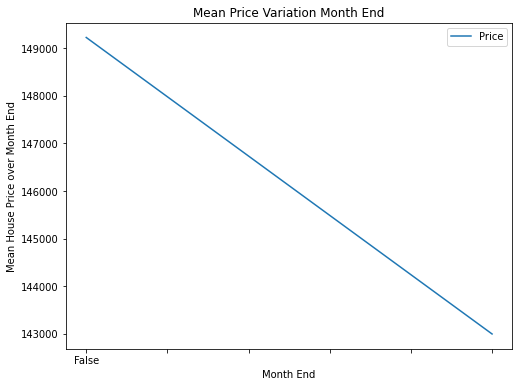

In [ ]:
#Date of TransferIs_month_end
#Date of TransferIs_month_start
#Date of TransferIs_quarter_end
#Date of TransferIs_quarter_start


Paid_Price_series=Paid_Price.groupby(['Date of TransferIs_month_end'])['Price'].mean().reset_index()
Paid_Price_series.set_index('Date of TransferIs_month_end', inplace=True)
#Paid_Price_series=Paid_Price_series[Paid_Price_series['Price']<500000]
ax=Paid_Price_series.plot(figsize= (8,6),title = 'Mean Price Variation Month End')#, xlabel='Years',ylabel = 'Mean Price Variation over Years')

# Set the x-axis label
ax.set_xlabel("Month End")

# Set the y-axis label
ax.set_ylabel("Mean House Price over Month End")

## Mean Price Appears to Drop at the End of Month

Text(0, 0.5, 'Mean House Price over Quater End')

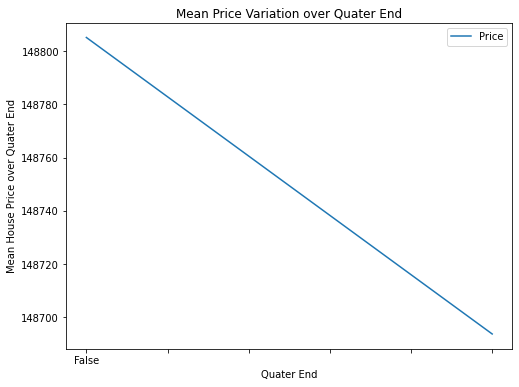

In [ ]:
#Date of TransferIs_month_end
#Date of TransferIs_month_start
#Date of TransferIs_quarter_end
#Date of TransferIs_quarter_start


Paid_Price_series=Paid_Price.groupby(['Date of TransferIs_quarter_end'])['Price'].mean().reset_index()
Paid_Price_series.set_index('Date of TransferIs_quarter_end', inplace=True)
#Paid_Price_series=Paid_Price_series[Paid_Price_series['Price']<500000]
ax=Paid_Price_series.plot(figsize= (8,6),title = 'Mean Price Variation over Quater End')#, xlabel='Years',ylabel = 'Mean Price Variation over Years')

# Set the x-axis label
ax.set_xlabel("Quater End")

# Set the y-axis label
ax.set_ylabel("Mean House Price over Quater End")

## At Quarer End Price Appears to be higher

## Merge Twitter Data Count with Price Data

In [ ]:
print(Paid_Price.shape)
Paid_Price_Tweet= pd.merge (Paid_Price, Cities , left_on= 'Town/City' ,  right_on = 'city_ascii', how='left')
print(Paid_Price_Tweet.shape)
Paid_Price_Tweet.head(3)

(4325454, 23)
(4341836, 32)


Transaction unique identifier  ...  Tweets_Count_001
0  {CD96F77F-BA83-48F8-8DF7-CDD0136EBC22}  ...               0.0
1  {416A7A2C-7A92-4350-A8DB-A9E9E089077C}  ...               1.0
2  {89F9548E-22FC-49F2-A3DE-3CA8734804D3}  ...               NaN

[3 rows x 32 columns]

In [ ]:
Paid_Price_Tweet.drop('Transaction unique identifier', axis=1, inplace=True)
Paid_Price_Tweet.drop('city_ascii', axis=1, inplace=True)
Paid_Price_Tweet.drop('Date of TransferElapsed', axis=1, inplace=True)

In [ ]:
#print(Paid_Price.shape)
#Paid_Price= pd.merge (Paid_Price, Cities , left_on= 'Town/City' ,  right_on = 'city_ascii', how='left')
#print(Paid_Price.shape)

## Model Data on using FAST.AI

In [ ]:

# Find Numerical and Categorical variables
Paid_Price_Tweet['Price'] = Paid_Price_Tweet['Price'].astype(float)
Paid_Price_Tweet.dtypes

Price                                float64
Property Type                         object
Old/New                               object
Duration                              object
Town/City                             object
District                              object
County                                object
PPDCategory Type                      object
Record Status - monthly file only     object
Date of TransferYear                   int64
Date of TransferMonth                  int64
Date of TransferWeek                   int64
Date of TransferDay                    int64
Date of TransferDayofweek              int64
Date of TransferDayofyear              int64
Date of TransferIs_month_end            bool
Date of TransferIs_month_start          bool
Date of TransferIs_quarter_end          bool
Date of TransferIs_quarter_start        bool
Date of TransferIs_year_end             bool
Date of TransferIs_year_start           bool
lat                                  float64
lng       

In [ ]:
#Defining the keyword arguments for fastai's TabularList

train_data = Paid_Price_Tweet
dep_var = 'Price'

cat_names = ['Property Type', 'Old/New', 'Duration', 'Town/City',
            'District', 'County', 'PPDCategory Type',
            'Record Status - monthly file only',
            'Date of TransferIs_month_end', 'Date of TransferIs_month_start',
            'Date of TransferIs_quarter_end', 'Date of TransferIs_quarter_start',
            'Date of TransferIs_year_end', 'Date of TransferIs_year_start']


cont_names = ['Date of TransferYear',	'Date of TransferMonth',	
              'Date of TransferWeek',	'Date of TransferDay',	
              'Date of TransferDayofweek',	'Date of TransferDayofyear',
              'lat',	'lng','population',	'Tweets_Count_1',	'Tweets_Count_05',
              'Tweets_Count_025',	'Tweets_Count_001'
              ]
path =''


train_data = train_data[cat_names + cont_names + [dep_var]]

#List of Processes/transforms to be applied to the dataset
procs = [FillMissing, Categorify, Normalize]

#Start index for creating a validation set from train_data
start_indx = len(train_data) - int(len(train_data) * 0.2)

#End index for creating a validation set from train_data
end_indx = len(train_data)


#TabularList for Validation
test = (TabularList.from_df(train_data.iloc[start_indx:end_indx].copy(), path=path, cat_names=cat_names, cont_names=cont_names))

#test = val


#TabularList for training
data = (TabularList.from_df(train_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(valid_pct = 0.1)
                           #.split_by_idx(list(range(start_indx,end_indx)))
                           .label_from_df(cols=dep_var, label_cls=FloatList)
                           .add_test(test)
                           .databunch())


In [ ]:
max_y = np.max(train_data['Price'])*1.2
y_range = torch.tensor([0, max_y], device=defaults.device)
y_range

tensor([     0.0000, 599998.8125], device='cuda:0')

In [ ]:
learn = tabular_learner(data, layers=[600,300], ps=[0.001,0.01], emb_drop=0.04, y_range=y_range, metrics=[rmse,r2_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


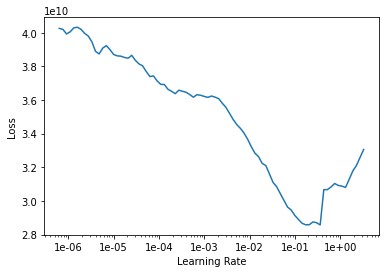

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 5e-2, wd=0.2)

In [ ]:
learn.save("Learn_Tabular")
learn.load("Learn_Tabular")

Learner(data=TabularDataBunch;

Train: LabelList (3907653 items)
x: TabularList
Property Type F; Old/New N; Duration L; Town/City HARROW; District HARROW; County GREATER LONDON; PPDCategory Type A; Record Status - monthly file only A; Date of TransferIs_month_end False; Date of TransferIs_month_start False; Date of TransferIs_quarter_end False; Date of TransferIs_quarter_start False; Date of TransferIs_year_end False; Date of TransferIs_year_start False; lat_na False; lng_na False; population_na True; Tweets_Count_1_na False; Tweets_Count_05_na False; Tweets_Count_025_na False; Tweets_Count_001_na False; Date of TransferYear 0.0094; Date of TransferMonth -1.7277; Date of TransferWeek -1.6492; Date of TransferDay 1.2045; Date of TransferDayofweek 0.8045; Date of TransferDayofyear -1.6185; lat -1.0644; lng 1.3278; population -0.2647; Tweets_Count_1 2.5410; Tweets_Count_05 3.0002; Tweets_Count_025 3.0747; Tweets_Count_001 -0.4153; ,Property Type T; Old/New N; Duration L; Town/City LIVERPO

In [ ]:

dep_var = 'Price'

cat_names = ['Property Type', 'Old/New', 'Duration', 'Town/City',
            'District', 'County', 'PPDCategory Type',
            'Record Status - monthly file only',
            'Date of TransferIs_month_end', 'Date of TransferIs_month_start',
            'Date of TransferIs_quarter_end', 'Date of TransferIs_quarter_start',
            'Date of TransferIs_year_end', 'Date of TransferIs_year_start']


cont_names = ['Date of TransferYear',	'Date of TransferMonth',	
              'Date of TransferWeek',	'Date of TransferDay',	
              'Date of TransferDayofweek',	'Date of TransferDayofyear',
              'lat',	'lng','population',	'Tweets_Count_1',	'Tweets_Count_05',
              'Tweets_Count_025',	'Tweets_Count_001'
              ]
              
def preprocess(Paid_Price_Short):
    


    Paid_Price_Short['Date of Transfer'] = pd.to_datetime(Paid_Price_Short['Date of Transfer'])
    add_datepart(Paid_Price_Short, 'Date of Transfer')
    Paid_Price_Short = Paid_Price_Short.loc[(Paid_Price_Short['Price'] < (500000)) & (Paid_Price_Short['Price'] > (10000))]


    Paid_Price_Short_Tweet= pd.merge (Paid_Price_Short, Cities , left_on= 'Town/City' ,  right_on = 'city_ascii', how='left')
    Paid_Price_Short_Tweet.drop('Transaction unique identifier', axis=1, inplace=True)
    Paid_Price_Short_Tweet.drop('city_ascii', axis=1, inplace=True)
    Paid_Price_Short_Tweet.drop('Date of TransferElapsed', axis=1, inplace=True)
    Paid_Price_Short_Tweet['Price'] = Paid_Price_Short_Tweet['Price'].astype(float)
    
    train_data = Paid_Price_Short_Tweet
    train_data = train_data[cat_names + cont_names + [dep_var]]
    data = (TabularList.from_df(train_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_rand_pct(valid_pct = 0.1)
                           #.split_by_idx(list(range(start_indx,end_indx)))
                           .label_from_df(cols=dep_var, label_cls=FloatList)
                           #.add_test(test)
                           .databunch())
    
    
   
    learn = tabular_learner(data, layers=[600,300], ps=[0.001,0.01], emb_drop=0.04, y_range=y_range, metrics=[rmse,r2_score])
    #if COUNT !=0:
    learn.load("Learn_Tabular",strict=False,remove_module=True)
    

    #learn.fit_one_cycle(1, 5e-2, wd=0.2)
    learn.save("Learn_Tabular")
    #print(COUNT)
    #COUNT=COUNT+1


reader  = pd.read_csv("/content/drive/My Drive/10FA/price_paid_records.csv", chunksize=65536) # chunksize depends with you RAM
[preprocess(r) for r in reader]

In [ ]:
#

In [ ]:
#Initializing the network
#learn = tabular_learner(data, layers=[300, 120], metrics= [rmse,r2_score])
#learn.summary